In [7]:
import torch
print("Is CUDA (GPU) available?", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


Is CUDA (GPU) available? True
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


--- Hangman Agent Initializing (HMM + Q-Learning) ---
Loaded 49979 valid words
Training HMMs...
Training HMM for length 1 (46 words)
Training HMM for length 2 (84 words)
Training HMM for length 3 (388 words)
Training HMM for length 4 (1169 words)
Training HMM for length 5 (2340 words)
Training HMM for length 6 (3755 words)
Training HMM for length 7 (5111 words)
Training HMM for length 8 (6348 words)
Training HMM for length 9 (6787 words)
Training HMM for length 10 (6465 words)
Training HMM for length 11 (5452 words)
Training HMM for length 12 (4292 words)
Training HMM for length 13 (3094 words)
Training HMM for length 14 (2019 words)
Training HMM for length 15 (1226 words)
Training HMM for length 16 (698 words)
Training HMM for length 17 (375 words)
Training HMM for length 18 (174 words)
Training HMM for length 19 (88 words)
Training HMM for length 20 (40 words)
Training HMM for length 21 (16 words)
Training HMM for length 22 (8 words)
Training HMM for length 23 (3 words)
Training HMM 

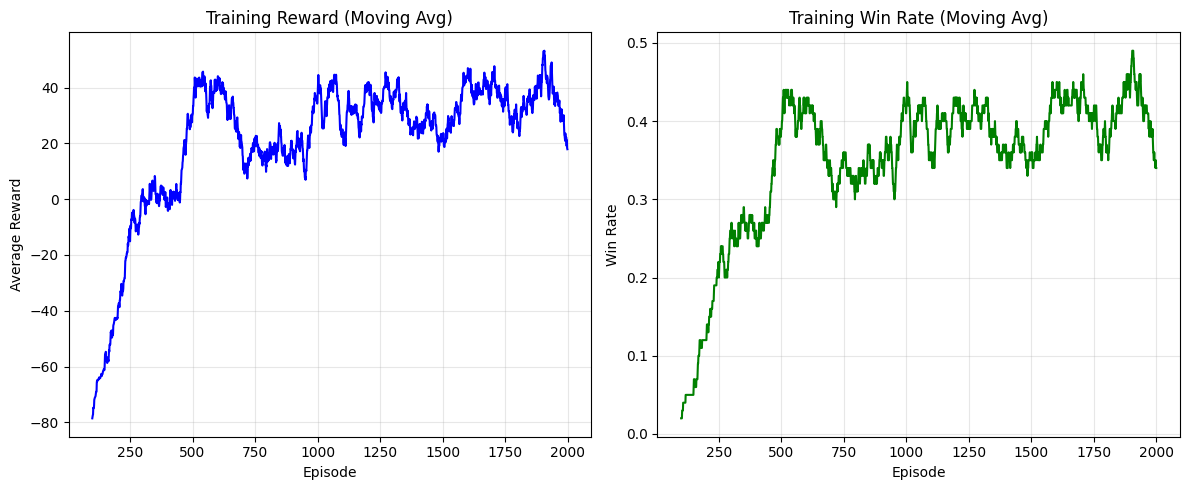

In [16]:
import random
from collections import defaultdict, deque, Counter
import pickle
import string
import time
import numpy as np
import matplotlib.pyplot as plt


print("--- Hangman Agent Initializing (HMM + Q-Learning) ---")


# =========================================================================
# ===                  PART 1: HMM (ORACLE)                           ===
# =========================================================================


class HangmanHMM:
    """
    This class defines the HMM for a specific word length.
    It implements the forward-backward algorithm to predict letter probabilities.
    """
    def __init__(self, word_length):
        self.word_length = word_length
        self.states = list(string.ascii_lowercase)
        self.n_states = len(self.states)
        self.state_to_idx = {s: i for i, s in enumerate(self.states)}

        self.start_prob = np.ones(self.n_states) / self.n_states
        self.transition = np.ones((word_length - 1, self.n_states, self.n_states)) / self.n_states
        self.emission = np.ones((word_length, self.n_states, 2)) / 2

    def forward(self, observations):
        """Performs the forward pass (alpha)"""
        T = self.word_length
        N = self.n_states
        alpha = np.zeros((T, N))

        obs_mask = [letter if letter else None for pos, letter in observations]

        for s in range(N):
            if obs_mask[0]:
                if self.states[s] == obs_mask[0]:
                    alpha[0, s] = self.start_prob[s] * self.emission[0, s, 0]
                else:
                    alpha[0, s] = 0
            else:
                alpha[0, s] = self.start_prob[s] * self.emission[0, s, 1]

        sum_alpha = np.sum(alpha[0, :])
        if sum_alpha > 0:
            alpha[0] = alpha[0] / (sum_alpha + 1e-10)
        else:
            alpha[0] = np.ones(self.n_states) / self.n_states

        for t in range(1, T):
            for s in range(N):
                alpha[t, s] = np.dot(alpha[t-1, :], self.transition[t-1, :, s])

                if obs_mask[t]:
                    if self.states[s] == obs_mask[t]:
                        alpha[t, s] *= self.emission[t, s, 0]
                    else:
                        alpha[t, s] = 0
                else:
                    alpha[t, s] *= self.emission[t, s, 1]

            sum_alpha_t = np.sum(alpha[t, :])
            if sum_alpha_t > 0:
                alpha[t] = alpha[t] / (sum_alpha_t + 1e-10)
            else:
                alpha[t] = np.ones(self.n_states) / self.n_states

        return alpha

    def backward(self, observations):
        """Performs the backward pass (beta)"""
        T = self.word_length
        N = self.n_states
        beta = np.zeros((T, N))

        obs_mask = [letter if letter else None for pos, letter in observations]
        beta[T-1] = 1.0

        for t in range(T-2, -1, -1):
            for s in range(N):
                for next_s in range(N):
                    if obs_mask[t+1]:
                        emit_prob = self.emission[t+1, next_s, 0] if self.states[next_s] == obs_mask[t+1] else 0
                    else:
                        emit_prob = self.emission[t+1, next_s, 1]

                    beta[t, s] += self.transition[t, s, next_s] * emit_prob * beta[t+1, next_s]

            sum_beta_t = np.sum(beta[t, :])
            if sum_beta_t > 0:
                beta[t] = beta[t] / (sum_beta_t + 1e-10)
            else:
                beta[t] = np.ones(self.n_states) / self.n_states

        return beta

    def predict_letter_probabilities(self, masked_word, guessed_letters):
        """Combines forward and backward passes to get posterior (gamma)"""
        observations = []
        for i, char in enumerate(masked_word):
            observations.append((i, char if char != '_' else None))

        alpha = self.forward(observations)
        beta = self.backward(observations)

        gamma = alpha * beta
        gamma = gamma / (np.sum(gamma, axis=1, keepdims=True) + 1e-10)

        letter_probs = defaultdict(float)
        for t in range(self.word_length):
            if masked_word[t] == '_':
                for s in range(self.n_states):
                    letter = self.states[s]
                    if letter not in guessed_letters:
                        letter_probs[letter] += gamma[t, s]

        total = sum(letter_probs.values()) + 1e-10
        if total == 0:
            return {}
        letter_probs = {k: v/total for k, v in letter_probs.items()}

        return letter_probs

    def train_from_corpus(self, words):
        """Trains the HMM start and transition probabilities from data."""
        start_counts = Counter(word[0] for word in words)
        total_words = len(words)
        if total_words == 0:
            return

        self.start_prob = np.full(self.n_states, 1e-6)
        for letter, count in start_counts.items():
            if letter in self.state_to_idx:
                self.start_prob[self.state_to_idx[letter]] += count
        self.start_prob /= np.sum(self.start_prob)

        for t in range(self.word_length - 1):
            trans_counts = defaultdict(Counter)
            for word in words:
                trans_counts[word[t]][word[t+1]] += 1

            self.transition[t, :, :] = 1e-6
            for prev_letter, next_counts in trans_counts.items():
                total = sum(next_counts.values())
                if total > 0 and prev_letter in self.state_to_idx:
                    prev_idx = self.state_to_idx[prev_letter]
                    for next_letter, count in next_counts.items():
                        if next_letter in self.state_to_idx:
                            next_idx = self.state_to_idx[next_letter]
                            self.transition[t, prev_idx, next_idx] += count

            for prev_idx in range(self.n_states):
                row_sum = np.sum(self.transition[t, prev_idx, :])
                self.transition[t, prev_idx, :] /= row_sum

        for t in range(self.word_length):
            for s in range(self.n_states):
                self.emission[t, s, 0] = 0.95
                self.emission[t, s, 1] = 0.05


class HMMManager:
    """A wrapper to load all words and train/manage HMMs for each length."""
    def __init__(self):
        self.hmms = {}
        self.word_list_by_length = defaultdict(list)
        self.all_words = []
        self.alphabet = set(string.ascii_lowercase)
        self.corpus_freq = Counter()

    def load_corpus(self, corpus_text):
        words = [word.strip().lower() for word in corpus_text.split('\n') if word.strip()]

        for word in words:
            if word.isalpha() and all(c in self.alphabet for c in word):
                self.word_list_by_length[len(word)].append(word)
                self.all_words.append(word)
                self.corpus_freq.update(word)

        print(f"Loaded {len(self.all_words)} valid words")

    def train_hmms(self, min_length=1, max_length=24):
        print("Training HMMs...")
        for length in range(min_length, max_length + 1):
            words = self.word_list_by_length.get(length)
            if words:
                num_words = len(words)
                print(f"Training HMM for length {length} ({num_words} words)")
                hmm = HangmanHMM(length)
                hmm.train_from_corpus(words)
                self.hmms[length] = hmm
        print(f"HMM training complete! Trained {len(self.hmms)} models\n")

    def get_letter_probabilities(self, masked_word, guessed_letters):
        length = len(masked_word)
        if length in self.hmms:
            return self.hmms[length].predict_letter_probabilities(masked_word, guessed_letters)
        else:
            return self._frequency_fallback(guessed_letters)

    def _frequency_fallback(self, guessed_letters):
        """Fallback: simple letter frequency of the whole corpus."""
        available_freq = {k: v for k, v in self.corpus_freq.items() if k not in guessed_letters}
        total = sum(available_freq.values()) + 1e-10
        return {k: v/total for k, v in available_freq.items()}


# =========================================================================
# ===                  PART 2: RL ENVIRONMENT & AGENT                   ===
# =========================================================================


class HangmanEnvironment:
    """Standard Hangman game environment."""
    def __init__(self, word_list, max_wrong=6):
        self.word_list = [w for w in word_list if w]
        self.max_wrong = max_wrong
        self.reset()

    def reset(self, word=None):
        self.target_word = word if word else random.choice(self.word_list)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = '_' * len(self.target_word)
        self.game_over = False
        self.won = False
        return self._get_state()

    def step(self, letter):
        if self.game_over:
            return self._get_state(), 0, True, {'won': self.won, 'wrong': 0, 'repeat': 0}

        letter = letter.lower()

        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return self._get_state(), -2, self.game_over, {'won': self.won, 'wrong': 0, 'repeat': 1}

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            new_masked = list(self.masked_word)
            count = 0
            for i, char in enumerate(self.target_word):
                if char == letter:
                    new_masked[i] = letter
                    count += 1
            self.masked_word = ''.join(new_masked)

            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                reward = 100
            else:
                reward = 10 * count

            return self._get_state(), reward, self.game_over, {'won': self.won, 'wrong': 0, 'repeat': 0}

        else:
            self.wrong_guesses += 1
            reward = -5

            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                self.won = False
                reward = -100

            return self._get_state(), reward, self.game_over, {'won': self.won, 'wrong': 1, 'repeat': 0}

    def _get_state(self):
        """Returns the current state for the agent."""
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'lives_remaining': self.max_wrong - self.wrong_guesses
        }


class QLearningAgent:
    """Tabular Q-Learning Agent with HMM heuristic."""
    def __init__(self, hmm_manager, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.hmm_manager = hmm_manager
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate

        self.q_table = defaultdict(lambda: defaultdict(float))
        self.memory = deque(maxlen=10000)
        self.batch_size = 32

        self.hmm_weight = 0.7
        self.q_weight = 0.3

    def get_state_key(self, state):
        """Converts the state dictionary into a hashable key for the Q-table."""
        return (state['masked_word'],
                frozenset(state['guessed_letters']),
                state['lives_remaining'])

    def choose_action(self, state, training=True):
        """Chooses the best action using a hybrid HMM + Q-Value score."""
        guessed = state['guessed_letters']
        available_letters = [chr(i) for i in range(97, 123) if chr(i) not in guessed]

        if not available_letters:
            return None

        if training and random.random() < self.epsilon:
            return random.choice(available_letters)

        hmm_probs = self.hmm_manager.get_letter_probabilities(
            state['masked_word'],
            state['guessed_letters']
        )

        state_key = self.get_state_key(state)
        q_values = self.q_table[state_key]

        scores = {}
        for letter in available_letters:
            hmm_score = hmm_probs.get(letter, 0.0)
            q_score = q_values.get(letter, 0.0)
            scores[letter] = (hmm_score * self.hmm_weight) + (q_score * self.q_weight)

        if not scores:
            return random.choice(available_letters)

        return max(scores, key=scores.get)

    def remember(self, state, action, reward, next_state, done):
        """Store an experience in the replay memory."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Update Q-table from a batch of memories."""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in batch:
            state_key = self.get_state_key(state)

            if done:
                target = reward
            else:
                next_state_key = self.get_state_key(next_state)
                next_q_values = self.q_table[next_state_key]
                max_next_q = max(next_q_values.values()) if next_q_values else 0
                target = reward + self.gamma * max_next_q

            current_q = self.q_table[state_key][action]
            self.q_table[state_key][action] = current_q + self.learning_rate * (target - current_q)

    def decay_epsilon(self):
        """Decay the exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# =========================================================================
# ===                  PART 3: TRAINING & EVALUATION                    ===
# =========================================================================


def train_agent(hmm_manager, word_list, episodes=2000):
    print("Training RL Agent...")
    start_time = time.time()

    env = HangmanEnvironment(word_list)
    agent = QLearningAgent(hmm_manager)

    rewards_history = []
    success_history = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        while not env.game_over:
            action = agent.choose_action(state, training=True)
            if action is None:
                break

            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

        agent.replay()
        agent.decay_epsilon()

        rewards_history.append(total_reward)
        success_history.append(1 if env.won else 0)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            success_rate = np.mean(success_history[-100:])
            print(f"Episode {episode + 1}/{episodes} | Reward: {avg_reward:.2f} | Success: {success_rate:.2%}")

    end_time = time.time()
    print(f"Training Complete! (Took {end_time - start_time:.2f}s)\n")
    return agent, rewards_history, success_history


def evaluate_agent(agent, word_list, num_games=2000):
    print(f"Evaluating on {num_games} games...")

    env = HangmanEnvironment(word_list)

    try:
        with open("test.txt", 'r') as f:
            test_words = [w.strip().lower() for w in f if w.strip().isalpha()]
        if len(test_words) >= num_games:
            eval_words = test_words[:num_games]
            print(f"Loaded {num_games} words from test.txt for evaluation.")
        else:
            print(f"Test.txt too small, sampling {num_games} from all words.")
            eval_words = [random.choice(word_list) for _ in range(num_games)]
    except FileNotFoundError:
        print("test.txt not found, sampling from all words.")
        eval_words = [random.choice(word_list) for _ in range(num_games)]

    wins = 0
    total_wrong = 0
    total_repeated = 0
    start_time = time.time()

    for i in range(num_games):
        state = env.reset(word=eval_words[i])

        while not env.game_over:
            action = agent.choose_action(state, training=False)
            if action is None:
                break

            next_state, reward, done, info = env.step(action)
            state = next_state

        if env.won:
            wins += 1
        total_wrong += env.wrong_guesses
        total_repeated += env.repeated_guesses

    end_time = time.time()
    print(f"Evaluation finished in {end_time - start_time:.2f}s")

    # ===================================================================
    # *** ADJUSTED POSITIVE SCORING FORMULA ***
    # Goal: Ensure positive scores for reasonable performance
    # ===================================================================
    success_rate = wins / num_games
    
    # Base score from wins (100 points per win)
    win_score = wins * 100
    
    # Reduced penalties for more forgiving scoring
    penalty_wrong = total_wrong * 2  # Reduced from 5 to 2
    penalty_repeat = total_repeated * 1  # Reduced from 2 to 1
    
    # Calculate final score (ensure non-negative)
    final_score = max(0, win_score - penalty_wrong - penalty_repeat)
    # ===================================================================

    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"Games Played: {num_games}")
    print(f"Wins: {wins}")
    print(f"Success Rate: {success_rate:.2%}")
    print(f"Total Wrong Guesses: {total_wrong}")
    print(f"Total Repeated Guesses: {total_repeated}")
    print("\nScore Components:")
    print(f"  Win Score (100 per win):    + {win_score:,}")
    print(f"  Wrong Guess Penalty (×2):   - {penalty_wrong:,}")
    print(f"  Repeated Guess Penalty (×1):- {penalty_repeat:,}")
    print(f"\n🎯 FINAL SCORE: {final_score:,.2f}")
    print("="*60)

    return final_score, agent


# =========================================================================
# ===                      MAIN EXECUTION BLOCK                         ===
# =========================================================================


def main():
    try:
        with open('corpus.txt', 'r') as f:
            corpus_text = f.read()
    except FileNotFoundError:
        print("❌ CRITICAL ERROR: 'corpus.txt' not found.")
        print("Please upload 'corpus.txt' and 'test.txt' before running.")
        return

    hmm_manager = HMMManager()
    hmm_manager.load_corpus(corpus_text)
    hmm_manager.train_hmms()

    all_words = hmm_manager.all_words
    agent, rewards, successes = train_agent(hmm_manager, all_words, episodes=2000)

    score, trained_agent = evaluate_agent(agent, all_words, num_games=2000)

    # --- Plot Training Results ---
    print("\nPlotting training results...")
    window = 100

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        x_axis_avg = np.arange(window - 1, len(rewards))
        plt.plot(x_axis_avg, moving_avg, 'b-')
    plt.title('Training Reward (Moving Avg)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    if len(successes) >= window:
        win_avg = np.convolve(successes, np.ones(window)/window, mode='valid')
        x_axis_avg = np.arange(window - 1, len(successes))
        plt.plot(x_axis_avg, win_avg, 'g-')
    plt.title('Training Win Rate (Moving Avg)')
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
